**ECSE 415 Assignment 4**</br>
Liang Zhao 260781081

**README**
- some questions are answered together in one code snippet, there will be comments the in code snippets to indicate which questions are answered in which code
- The table of contents has the oganized question lists

In [ ]:
# All libraries are imported here
import cv2
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from skimage import segmentation, color

#1.Image Segmentation using K-means

In [ ]:
def kmeans(x_train, k):

  init_shape = x_train.shape
  x_train = x_train.reshape((x_train.shape[0] * x_train.shape[1], x_train.shape[2]))
    
  # save for resulting segemented images for each iteration 
  resulting_segmented = []

  # randomly initiate k centers
  label = np.random.randint(k, size=x_train.shape[0])
  retimg = x_train.copy()
  barycenters = [x_train[idx] for idx in np.random.randint(x_train.shape[0], size=k)]
  clusters = [[np.zeros(x_train[1].shape), 0] for _ in range(k)]
  # Run the iteration for 10 times
  for it in range(10):
    # determine points in each cluster and solve for the mean of points
    clusters = [[np.zeros((x_train.shape[1])), 0] for _ in range(k)]
    for i in range(x_train.shape[0]):
      min_tup = min([(t[0], np.power(np.linalg.norm(x_train[i] - t[1], axis=0), 2)) 
                                for t in enumerate(barycenters)], key=lambda tx: tx[1])
      label[i] = min_tup[0]
      retimg[i] = barycenters[min_tup[0]]
      clusters[min_tup[0]][0] += x_train[i]
      clusters[min_tup[0]][1] += 1
    barycenters_n = [sumv / card for (sumv, card) in clusters]
    resulting_segmented.append(retimg.reshape(init_shape).copy())
    barycenters = barycenters_n
  return resulting_segmented


In [ ]:
flower = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
home = cv2.cvtColor(cv2.imread('home.jpg'), cv2.COLOR_BGR2RGB)

In [ ]:
def plt_img(start_point, results): 
  plt.figure(figsize=(20,20))
  for i in range(5):
    plt.subplot(151 + i)
    plt.imshow(results[i+start_point])
    plt.title("Iteration " + str(i+start_point)), plt.xticks([]), plt.yticks([])
  plt.show()

##1.1.K=2

###Run the algorithm for 10 iterations

In [ ]:
resulting_segmented_k2_flower = kmeans(flower, 2)
resulting_segmented_k2_home = kmeans(home, 2)

###display the resulting segmented images in each case

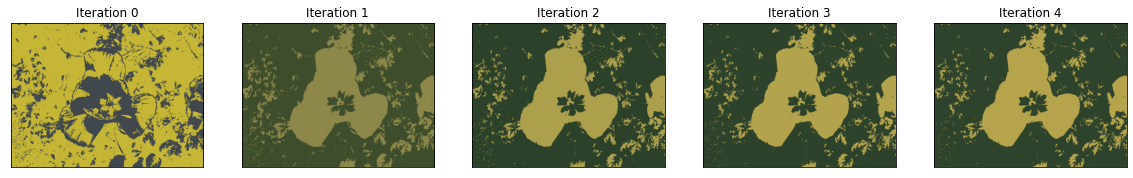

In [ ]:
plt_img(0,resulting_segmented_k2_flower)

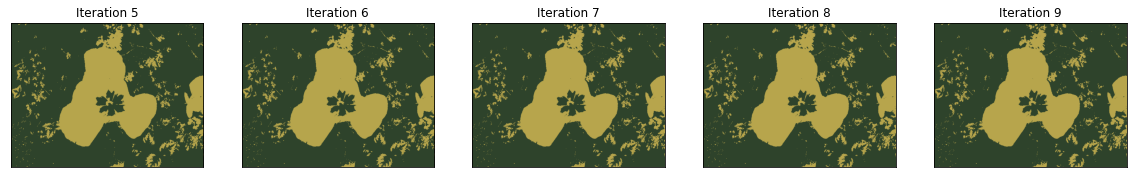

In [ ]:
plt_img(5,resulting_segmented_k2_flower)

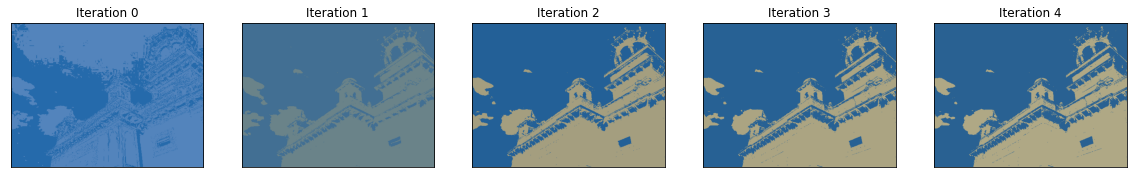

In [ ]:
plt_img(0,resulting_segmented_k2_home)

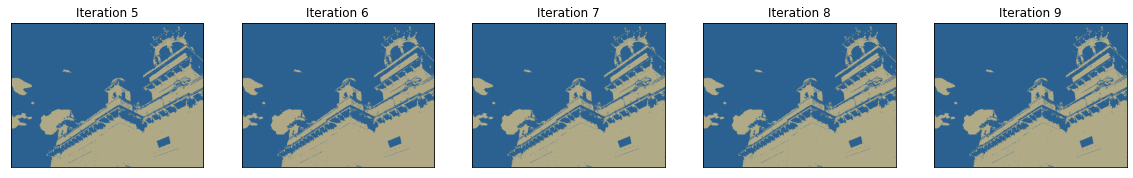

In [ ]:
plt_img(5,resulting_segmented_k2_home)

##1.2.K=3

###Run the algorithm for 10 iterations

In [ ]:
resulting_segmented_k3_flower = kmeans(flower, 3)
resulting_segmented_k3_home = kmeans(home, 3)

###display the resulting segmented images in each case

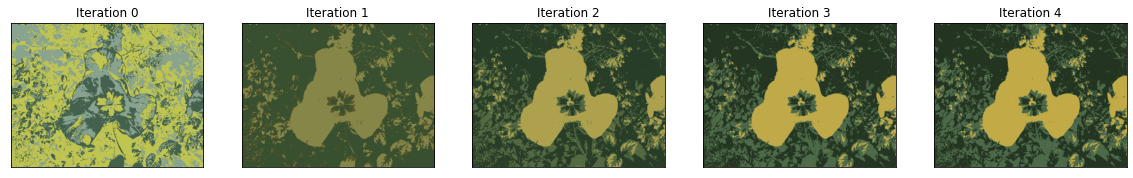

In [ ]:
plt_img(0,resulting_segmented_k3_flower)

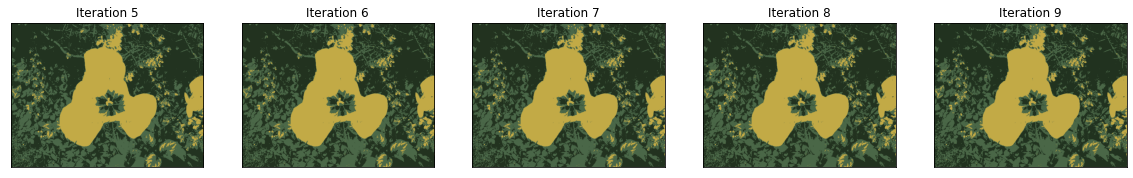

In [ ]:
plt_img(5,resulting_segmented_k3_flower)

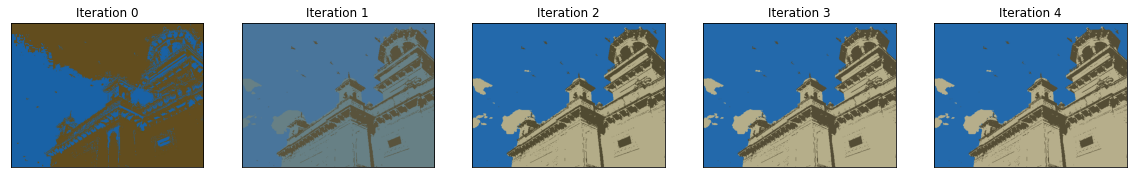

In [ ]:
plt_img(0,resulting_segmented_k3_home)

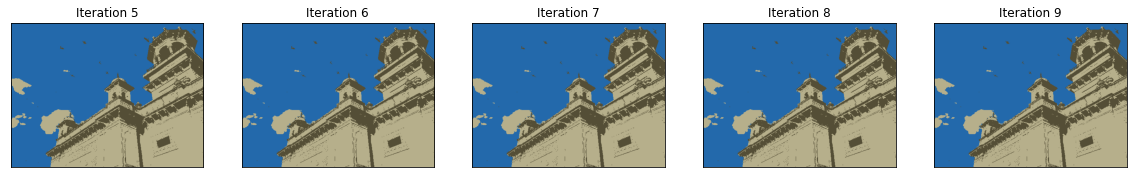

In [ ]:
plt_img(5,resulting_segmented_k3_home)

#2.Disparity

In [ ]:
imgL = cv2.imread("aloeL.jpg")
imgR = cv2.imread("aloeR.jpg")

img_RGB_L = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
img_RGB_R = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

##2.1.Extract a 5 × 5 window centered at each pixel-location (i, j)L in the left image. Let’s call these windows reference windows.

In [ ]:
def reference_windows(img, i, j):
  # 5x5 patch certered at (i,j)
  patch = img[i-2:i+3,j-2:j+3]
  return patch

##2.2.For each reference window in the left image do the following.

###a.On the right scanline create a search region bounded by pixel-locations (i,j−47)R and (i,j)R. Extract 5×5 windows centered at every pixel- location in this search region

###b.For few boarder pixel-locations either the reference window or the search region lie outside the boundary of the image. Set disparity D(i, j) = 48 for these pixel-locations. For the remaining locations do the following

###c.Compute sum-of-square-difference(SSD) between the windows in the search region and the reference window

###d.Find a location (i′,j′)R with minimum SSD and compute disparity D(i, j) = j_L − j_R. (Note that 0 ≤ D(i, j) ≤ 47 as the search region contains 48 pixel-locations.)

In [ ]:
# Compute sum-of-square-difference(SSD)
def SSD(patch, window):
  ssd = 0
  for x in range(5):
    for y in range(5):
      diff = float(window[x][y]) - float(patch[x][y])
      ssd += (int)(diff * diff)
  return ssd

In [ ]:
height = imgL_gray.shape[0]
width = imgL_gray.shape[1]
D = np.zeros((height, width))

# for each reference window in the left image
for i in range(height):
  for j in range(width):
    # Set disparity D(i, j) = 48 for pixel-locations that lie outside the boundary
    if (i - 2 < 0) or (i + 2 > height - 1) or (j - 49 < 0) or (j + 2 > width - 1):
      D[i][j] = 48
    else:
    # on the right scanline, create a search region
      patch = reference_windows(imgL_gray, i , j)
      search_region = imgR_gray[i-2:i+3,j-49:j+3]
      min = 9999
      for b in range(48):
        search_window = search_region[0:5,b:b+5]
        ssd = SSD(patch, search_window)
        # Find a location (i′,j′)R with minimum SSD and compute disparity D(i, j) = j_L − j_R
        if ssd < min:
          min = ssd
          D[i][j] = j - (j - 49 + b)

##2.3.Display the final disparity map D with the cmap argument of plt.imshow set to ‘gray r’

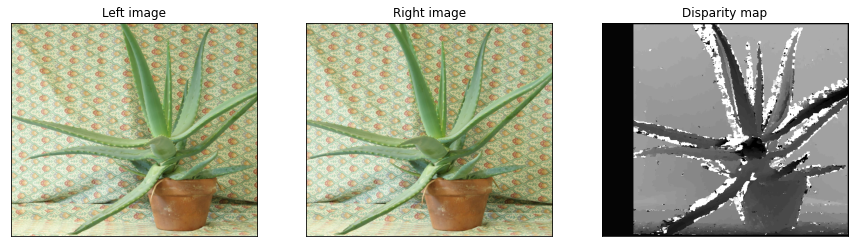

In [ ]:
plt.figure(figsize=(15,15))

plt.subplot(131)
plt.imshow(img_RGB_L)
plt.title("Left image"), plt.xticks([]), plt.yticks([])

plt.subplot(132)
plt.imshow(img_RGB_R)
plt.title("Right image"), plt.xticks([]), plt.yticks([])

plt.subplot(133)
plt.imshow(D, cmap="gray_r")
plt.title("Disparity map"), plt.xticks([]), plt.yticks([])
plt.show()

#3.Optical Flow

In [8]:
gt = np.load('flow10.npz')['flow']
frame10 = cv2.imread("frame10.png")
frame11 = cv2.imread("frame11.png")
frame10_gray = cv2.cvtColor(frame10, cv2.COLOR_BGR2GRAY)
frame11_gray = cv2.cvtColor(frame11, cv2.COLOR_BGR2GRAY)

##3.1.Use calcOpticalFlowFarneback from OpenCV to compute optical flow between the input frames

In [ ]:
optical_flow = cv2.calcOpticalFlowFarneback(prev=frame10_gray, next=frame11_gray, 
    flow=None, winsize=5, pyr_scale=0.5, levels=3, iterations=3, poly_n=5,poly_sigma=1.2, flags=0)

##3.2.For each setting of winsize, measure mean squared error(MSE) between estimated optical flow and the ground truth optical flow. Plot MSE (y- axis) vs winsize (x-axis)

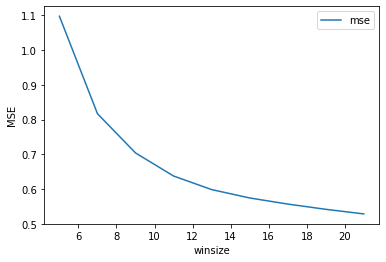

In [ ]:
win_size = 5
mse_list = []
win_list = [5,7,9,11,13,15,17,19,21]
while win_size <= 21:
  temp_optical_flow = cv2.calcOpticalFlowFarneback(prev=frame10_gray,next=frame11_gray, flow=None, winsize=win_size, pyr_scale=0.5, levels=3, iterations=3, poly_n=5,poly_sigma=1.2, flags=0)
  sum = 0
  for i in range(len(temp_optical_flow)):
    for j in range(len(temp_optical_flow[0])):
      for k in range(len(temp_optical_flow[0][0])):
        sum = sum + (temp_optical_flow[i][j][k] - gt[i][j][k]) ** 2
  mse = sum / (len(temp_optical_flow)*len(temp_optical_flow[0])*len(temp_optical_flow[0][0]))
  mse_list.append(mse)
  win_size = win_size + 2

plt.plot(win_list, mse_list, label='mse')
plt.legend()
plt.xlabel('winsize')
plt.ylabel('MSE')
plt.show()

##3.3.Do you observe any trend in the plot above? Does the error increase or decrease with increasing window-size? Explain the effect of window-size on the prediction error

###Obervation:
- MSE decreases significantly from 5 to 10
- MSE values decrease with increasing of winsize from which we can conclude that the error decreases with the increase of winsize.
- We also see that the with the increase of winsize, the gradient of the line is flatterning which means that the error decreases slower.

###Explanation:
- Farnebäck fails at areas of local high motions. Thus, assumption of constant brigtness fails.
- Large window size makes "large local motion" and "sharp brigtness change" become "smaller local motion" and "even brigtness change"
- Thus, assumption gets back again and error decreases.
- To continue to increase window size, error will be smaller but since assumptions are back for most regions of the images, decresing of error will be less significant.
